In [1]:
#Import some tools

import numpy as np
import os, time
import pandas as pd
import sys

# Deep Learning imports
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Nadam, Adamax, RMSprop, SGD, Adagrad, SGD
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2, l1, l1_l2
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from keras.callbacks import EarlyStopping

# To plot nice figures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Loading data

In [2]:
df = pd.read_csv('diabetes.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
#Extract the feature names
features =  df.columns.tolist()
print(f"Feature names :{features}")

#Extract label names
labels =  df.groupby('Outcome').size().index.tolist()
#labels = np.unique(df['label'])
print(f"\nLabel names :{labels}")

Feature names :['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Label names :[0, 1]


## Visualisation

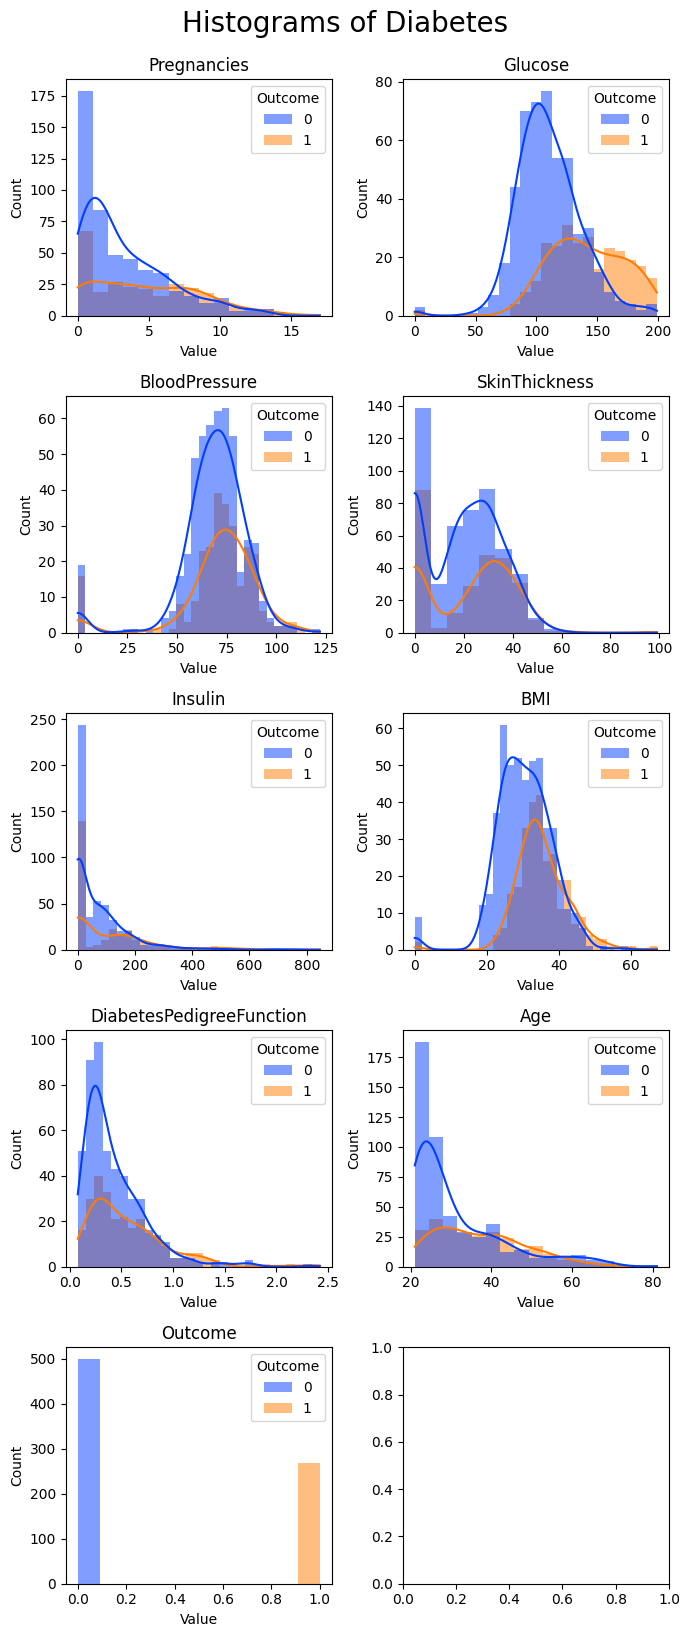

In [7]:
#Histogram plotting 

def histogram_plot(data, rows, cols, title='title'):
    ''' Generate histogram plotting 
        data : pandas dataframe
        rows : number of rows
        cols : number of columns
        title: Histogram title '''
    
    fig, axes = plt.subplots(rows, cols, figsize=(7, 16))  
    axes = axes.flatten()

    for ax, feature in zip(axes, features):
        sns.histplot(data=data, x=feature, hue="Outcome", bins='auto', kde=True, ax=ax, edgecolor=None, palette="bright")
        ax.set_title(feature, fontsize=12)  # Set the title for each subplot
        ax.set_xlabel('Value', fontsize=10)  # Set the x-axis label

    plt.tight_layout()
    fig.suptitle(title, fontsize=20, y=1.02)
    plt.show()


# Show features
histogram_plot(df[:], 5, 2, title='Histograms of Diabetes')


## Cleaning data

In [8]:
#Replace 0 values with NaN in the 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI' features
df['Glucose'] = np.where(df['Glucose'] == 0, np.nan, df['Glucose'])
df['BloodPressure'] = np.where(df['BloodPressure'] == 0, np.nan, df['BloodPressure'])
df['SkinThickness'] = np.where(df['SkinThickness'] == 0, np.nan, df['SkinThickness'])
df['Insulin'] = np.where(df['Insulin'] == 0, np.nan, df['Insulin'])
df['BMI'] = np.where(df['BMI'] == 0, np.nan, df['BMI'])

## Preprocessing data

In [9]:
# Impute missing values using median
df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']] = df[['Pregnancies', 
    'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 
    'DiabetesPedigreeFunction', 'Age']].fillna(df.median())

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[['Pregnancies', 'Glucose', 'BloodPressure', 
                                            'SkinThickness', 'Insulin', 'BMI', 
                                            'DiabetesPedigreeFunction', 'Age']])
df_scaled = pd.DataFrame(scaled_features, columns=['Pregnancies', 'Glucose', 
                                                   'BloodPressure', 'SkinThickness', 
                                                   'Insulin', 'BMI', 
                                                   'DiabetesPedigreeFunction', 'Age'])

# Add the label back to the scaled DataFrame
df_scaled['Outcome'] = df['Outcome'].values


In [10]:
# Features to impute and scale
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
            'Insulin', 'BMI', 'DiabetesPedigreeFunction']

# Impute with median
imputer = SimpleImputer(strategy='median')
df[features] = imputer.fit_transform(df[features])

# Scale with MinMaxScaler
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [11]:
# Step 1: Separate features and the label column
features = df.drop('Outcome', axis=1)  # Feature columns (A, B, C)
label = df['Outcome']  # Label column

# Step 2: Impute missing values using the median
imputer = SimpleImputer(strategy='median')
features_imputed = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

# Step 3: Scale features using Min-Max Scaler
scaler = MinMaxScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features_imputed), columns=features.columns)

# Step 4: Combine scaled features with the label column
df_scaled = pd.concat([features_scaled, label.reset_index(drop=True)], axis=1)
df_scaled['Outcome'] = df_scaled['Outcome'].astype('int32')

## Splitting dataset

In [12]:
#Split data using the stratify
bigtrain_set, test_set = train_test_split(df_scaled, test_size=0.2, random_state=24, stratify=df['Outcome'])
train_set, val_set = train_test_split(bigtrain_set, test_size=0.25, random_state=24, stratify=bigtrain_set['Outcome'])

#Get the X and y for train, val and test
X_train = train_set.iloc[:, :-1].values  
y_train = train_set.iloc[:, -1].values
X_test = test_set.iloc[:, :-1].values
y_test = test_set.iloc[:, -1].values
X_val = val_set.iloc[:, :-1].values
y_val = val_set.iloc[:, -1].values

#Check each dataset shape
print(f'Training set shapes: {[X_train.shape,y_train.shape]}')
print(f'Validation set shapes: {[X_val.shape,y_val.shape]}') 
print(f'Test set shapes: {[X_test.shape,y_test.shape]}')

Training set shapes: [(460, 8), (460,)]
Validation set shapes: [(154, 8), (154,)]
Test set shapes: [(154, 8), (154,)]


## Base Model

In [13]:
# Create single layer perceptron model
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid'))  # Single output neuron with sigmoid

# Compile the model
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_val, y_val))

# Get the validation accuracy from the history object
val_accuracy = history.history['val_accuracy']

# Find the maximum validation accuracy
max_val_accuracy = max(val_accuracy)

# Print the maximum validation accuracy
print(f'\nBase Model Max-validation accuracy: {max_val_accuracy}')



Epoch 1/100
15/15 [==============================] - 1s 15ms/step - loss: 0.6951 - accuracy: 0.6522 - val_loss: 0.7029 - val_accuracy: 0.6494
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 0.6945 - accuracy: 0.6522 - val_loss: 0.7021 - val_accuracy: 0.6494
Epoch 3/100
15/15 [==============================] - 0s 7ms/step - loss: 0.6939 - accuracy: 0.6522 - val_loss: 0.7014 - val_accuracy: 0.6494
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.6522 - val_loss: 0.7006 - val_accuracy: 0.6494
Epoch 5/100
15/15 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.6522 - val_loss: 0.6999 - val_accuracy: 0.6494
Epoch 6/100
15/15 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.6522 - val_loss: 0.6992 - val_accuracy: 0.6494
Epoch 7/100
15/15 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.6522 - val_loss: 0.6985 - val_accuracy: 0.6494
Epoch 8/100


5/5 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.65      1.00      0.79       100
    Diabetes       0.00      0.00      0.00        54

    accuracy                           0.65       154
   macro avg       0.32      0.50      0.39       154
weighted avg       0.42      0.65      0.51       154

Base Model Max-validation accuracy: 0.649350643157959


C:\Users\Asrul Sani\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Asrul Sani\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Asrul Sani\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

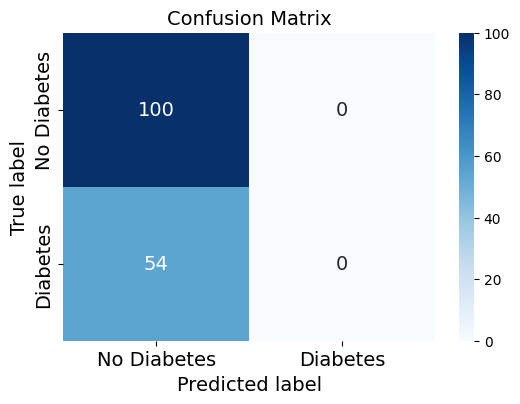

In [14]:
#Show some metrics results

# Get predictions
y_pred = (model.predict(X_val) > 0.5).astype(int)

# Calculate classification report
base_report = classification_report(y_val, y_pred, target_names=['No Diabetes', 'Diabetes'])
print(f'Classification Report:\n{base_report}')

# Get the maximum validation accuracy
base_max_val_accuracy = max(history.history['val_accuracy'])
print(f'Base Model Max-validation accuracy: {base_max_val_accuracy}')

# Calculate confusion matrix
base_cm = confusion_matrix(y_val, y_pred)

def plot_confusion_matrix(cm, classes, fontsize=14):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes, 
                annot_kws={"size": fontsize})  # Set annotation font size
    plt.ylabel('True label', fontsize=fontsize)
    plt.xlabel('Predicted label', fontsize=fontsize)
    plt.title('Confusion Matrix', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)  # Set x-tick label font size
    plt.yticks(fontsize=fontsize)  # Set y-tick label font size
    plt.show()

# Define class names
class_names = ['No Diabetes', 'Diabetes']

# Plot the confusion matrix
plot_confusion_matrix(base_cm, class_names, fontsize=14)


## Optimisation models

### Model Optimise 1

Increase epochs (500), change batch size (10), add L2 regularizer, change learning rate (0.05) and add early stopping.

In [15]:
# Define the model
model_opt1 = Sequential()
model_opt1.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid', kernel_regularizer=l2(0.00001)))  # Single output neuron with sigmoid

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Compile the model
optimizer = SGD(learning_rate=0.05) 
model_opt1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_opt1 = model_opt1.fit(X_train, y_train, 
                    epochs=500,  # Increase the number of epochs
                    batch_size=10,  # Increase batch size for stability
                    verbose=1, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping]
                    )

# Print the maximum validation accuracy
val_accuracy_opt1 = history_opt1.history['val_accuracy']
max_val_accuracy_opt1 = max(val_accuracy_opt1)
print(f'\nModel_opt1 Max-validation accuracy: {max_val_accuracy_opt1}')

Epoch 1/500
46/46 [==============================] - 1s 8ms/step - loss: 0.6914 - accuracy: 0.5348 - val_loss: 0.6670 - val_accuracy: 0.6364
Epoch 2/500
46/46 [==============================] - 0s 6ms/step - loss: 0.6562 - accuracy: 0.6478 - val_loss: 0.6519 - val_accuracy: 0.6623
Epoch 3/500
46/46 [==============================] - 0s 6ms/step - loss: 0.6458 - accuracy: 0.6435 - val_loss: 0.6451 - val_accuracy: 0.6623
Epoch 4/500
46/46 [==============================] - 0s 7ms/step - loss: 0.6399 - accuracy: 0.6457 - val_loss: 0.6393 - val_accuracy: 0.6623
Epoch 5/500
46/46 [==============================] - 0s 7ms/step - loss: 0.6349 - accuracy: 0.6435 - val_loss: 0.6337 - val_accuracy: 0.6623
Epoch 6/500
46/46 [==============================] - 0s 7ms/step - loss: 0.6297 - accuracy: 0.6457 - val_loss: 0.6283 - val_accuracy: 0.6623
Epoch 7/500
46/46 [==============================] - 0s 7ms/step - loss: 0.6249 - accuracy: 0.6522 - val_loss: 0.6231 - val_accuracy: 0.6623
Epoch 8/500
4

5/5 [==============================] - 0s 468us/step
Classification Report Model Opt-1:
              precision    recall  f1-score   support

 No Diabetes       0.78      0.91      0.84       100
    Diabetes       0.76      0.52      0.62        54

    accuracy                           0.77       154
   macro avg       0.77      0.71      0.73       154
weighted avg       0.77      0.77      0.76       154

Model Opt1 Max-validation accuracy: 0.7922077775001526


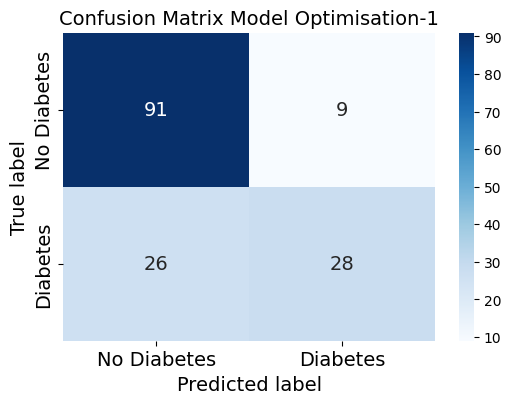

In [16]:
#Show some metrics results

# Get predictions
y_pred_opt1 = (model_opt1.predict(X_val) > 0.5).astype(int)

# Calculate classification report
opt1_report = classification_report(y_val, y_pred_opt1, target_names=['No Diabetes', 'Diabetes'])
print(f'Classification Report Model Opt-1:\n{opt1_report}')

# Get the maximum validation accuracy
opt1_max_val_accuracy = max(history_opt1.history['val_accuracy'])
print(f'Model Opt1 Max-validation accuracy: {opt1_max_val_accuracy}')

# Calculate confusion matrix
opt1_cm = confusion_matrix(y_val, y_pred_opt1)

def plot_confusion_matrix(cm, classes, fontsize=14):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes, 
                annot_kws={"size": fontsize})  # Set annotation font size
    plt.ylabel('True label', fontsize=fontsize)
    plt.xlabel('Predicted label', fontsize=fontsize)
    plt.title('Confusion Matrix Model Optimisation-1', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)  # Set x-tick label font size
    plt.yticks(fontsize=fontsize)  # Set y-tick label font size
    plt.show()

# Define class names
class_names = ['No Diabetes', 'Diabetes']

# Plot the confusion matrix
plot_confusion_matrix(opt1_cm, class_names, fontsize=14)


### Model Optimise 2

Shifting optimizer to Adam with learning rate 0.005.

In [17]:
# Define the model
model_opt2 = Sequential()
model_opt2.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid', kernel_regularizer=l2(0.00001)))  # Single output neuron with sigmoid

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Compile the model
optimizer = Adam(learning_rate=0.005) 
model_opt2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_opt2 = model_opt2.fit(X_train, y_train, 
                    epochs=500,  # Increase the number of epochs
                    batch_size=10,  # Increase batch size for stability
                    verbose=1, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping]
                    )

# Print the maximum validation accuracy
val_accuracy_opt2 = history_opt2.history['val_accuracy']
max_val_accuracy_opt2 = max(val_accuracy_opt2)
print(f'\nModel_opt2 Max-validation accuracy: {max_val_accuracy_opt2}')

Epoch 1/500
46/46 [==============================] - 1s 9ms/step - loss: 0.6604 - accuracy: 0.6565 - val_loss: 0.6578 - val_accuracy: 0.6494
Epoch 2/500
46/46 [==============================] - 0s 7ms/step - loss: 0.6523 - accuracy: 0.6587 - val_loss: 0.6499 - val_accuracy: 0.6494
Epoch 3/500
46/46 [==============================] - 0s 7ms/step - loss: 0.6454 - accuracy: 0.6587 - val_loss: 0.6425 - val_accuracy: 0.6494
Epoch 4/500
46/46 [==============================] - 0s 7ms/step - loss: 0.6392 - accuracy: 0.6630 - val_loss: 0.6355 - val_accuracy: 0.6558
Epoch 5/500
46/46 [==============================] - 0s 7ms/step - loss: 0.6336 - accuracy: 0.6609 - val_loss: 0.6291 - val_accuracy: 0.6558
Epoch 6/500
46/46 [==============================] - 0s 6ms/step - loss: 0.6280 - accuracy: 0.6587 - val_loss: 0.6232 - val_accuracy: 0.6558
Epoch 7/500
46/46 [==============================] - 0s 8ms/step - loss: 0.6224 - accuracy: 0.6587 - val_loss: 0.6174 - val_accuracy: 0.6623
Epoch 8/500
4

5/5 [==============================] - 0s 3ms/step
Classification Report Model Opt-2:
              precision    recall  f1-score   support

 No Diabetes       0.78      0.92      0.84       100
    Diabetes       0.78      0.52      0.62        54

    accuracy                           0.78       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.78      0.77       154

Model Opt2 Max-validation accuracy: 0.7792207598686218


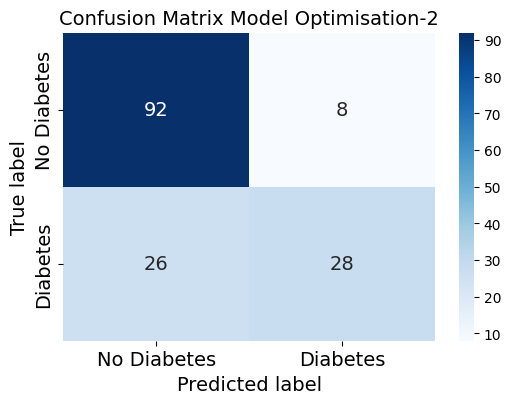

In [38]:
#Show some metrics results

# Get predictions
y_pred_opt2 = (model_opt2.predict(X_val) > 0.5).astype(int)

# Calculate classification report
opt2_report = classification_report(y_val, y_pred_opt2, target_names=['No Diabetes', 'Diabetes'])
print(f'Classification Report Model Opt-2:\n{opt2_report}')

# Get the maximum validation accuracy
opt2_max_val_accuracy = max(history_opt2.history['val_accuracy'])
print(f'Model Opt2 Max-validation accuracy: {opt2_max_val_accuracy}')

# Calculate confusion matrix
opt2_cm = confusion_matrix(y_val, y_pred_opt2)

def plot_confusion_matrix(cm, classes, fontsize=14):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes, 
                annot_kws={"size": fontsize})  # Set annotation font size
    plt.ylabel('True label', fontsize=fontsize)
    plt.xlabel('Predicted label', fontsize=fontsize)
    plt.title('Confusion Matrix Model Optimisation-2', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)  # Set x-tick label font size
    plt.yticks(fontsize=fontsize)  # Set y-tick label font size
    plt.show()

# Define class names
class_names = ['No Diabetes', 'Diabetes']

# Plot the confusion matrix
plot_confusion_matrix(opt2_cm, class_names, fontsize=14)


### Model Optimise 3

Shifting optimizer to RMSprop and adjusting the learning rate (0.001).

In [30]:
# Define the model
model_opt3 = Sequential()
model_opt3.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid', kernel_regularizer=l2(0.00001)))  # Single output neuron with sigmoid

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Compile the model
optimizer = RMSprop(learning_rate=0.001) 
model_opt3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_opt3 = model_opt3.fit(X_train, y_train, 
                    epochs=500,  # Increase the number of epochs
                    batch_size=10,  # Increase batch size for stability
                    verbose=1, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping]
                    )

# Print the maximum validation accuracy
val_accuracy_opt3 = history_opt3.history['val_accuracy']
max_val_accuracy_opt3 = max(val_accuracy_opt3)
print(f'\nModel_opt3 Max-validation accuracy: {max_val_accuracy_opt3}')

Epoch 1/500
46/46 [==============================] - 1s 11ms/step - loss: 0.6782 - accuracy: 0.6370 - val_loss: 0.6778 - val_accuracy: 0.6688
Epoch 2/500
46/46 [==============================] - 0s 8ms/step - loss: 0.6738 - accuracy: 0.6326 - val_loss: 0.6740 - val_accuracy: 0.6364
Epoch 3/500
46/46 [==============================] - 0s 8ms/step - loss: 0.6703 - accuracy: 0.6478 - val_loss: 0.6706 - val_accuracy: 0.6364
Epoch 4/500
46/46 [==============================] - 0s 8ms/step - loss: 0.6675 - accuracy: 0.6500 - val_loss: 0.6678 - val_accuracy: 0.6623
Epoch 5/500
46/46 [==============================] - 0s 7ms/step - loss: 0.6652 - accuracy: 0.6543 - val_loss: 0.6656 - val_accuracy: 0.6623
Epoch 6/500
46/46 [==============================] - 0s 8ms/step - loss: 0.6630 - accuracy: 0.6522 - val_loss: 0.6632 - val_accuracy: 0.6558
Epoch 7/500
46/46 [==============================] - 0s 8ms/step - loss: 0.6610 - accuracy: 0.6543 - val_loss: 0.6613 - val_accuracy: 0.6494
Epoch 8/500


5/5 [==============================] - 0s 3ms/step
Classification Report Model Opt-3:
              precision    recall  f1-score   support

 No Diabetes       0.76      0.91      0.83       100
    Diabetes       0.74      0.48      0.58        54

    accuracy                           0.76       154
   macro avg       0.75      0.70      0.71       154
weighted avg       0.76      0.76      0.74       154

Model Opt3 Max-validation accuracy: 0.7727272510528564


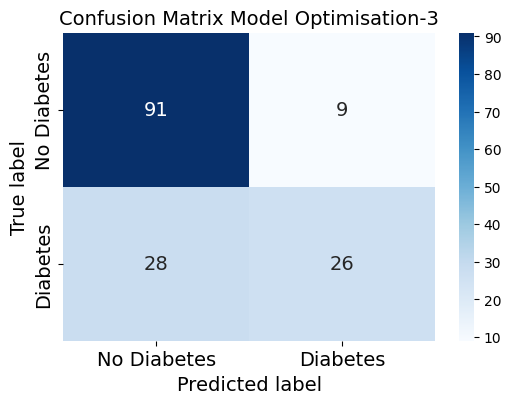

In [37]:
#Show some metrics results

# Get predictions
y_pred_opt3 = (model_opt3.predict(X_val) > 0.5).astype(int)

# Calculate classification report
opt3_report = classification_report(y_val, y_pred_opt3, target_names=['No Diabetes', 'Diabetes'])
print(f'Classification Report Model Opt-3:\n{opt3_report}')

# Get the maximum validation accuracy
opt3_max_val_accuracy = max(history_opt3.history['val_accuracy'])
print(f'Model Opt3 Max-validation accuracy: {opt3_max_val_accuracy}')

# Calculate confusion matrix
opt3_cm = confusion_matrix(y_val, y_pred_opt3)

def plot_confusion_matrix(cm, classes, fontsize=14):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes, 
                annot_kws={"size": fontsize})  # Set annotation font size
    plt.ylabel('True label', fontsize=fontsize)
    plt.xlabel('Predicted label', fontsize=fontsize)
    plt.title('Confusion Matrix Model Optimisation-3', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)  # Set x-tick label font size
    plt.yticks(fontsize=fontsize)  # Set y-tick label font size
    plt.show()

# Define class names
class_names = ['No Diabetes', 'Diabetes']

# Plot the confusion matrix
plot_confusion_matrix(opt3_cm, class_names, fontsize=14)


In [32]:
# Print the maximum validation accuracy
mean_val_accuracy_base = np.mean(val_accuracy)
print(f'\nModel_opt1 Mean-validation accuracy: {mean_val_accuracy_base}')

mean_val_accuracy_opt1 = np.mean(val_accuracy_opt1)
print(f'\nModel_opt1 Mean-validation accuracy: {mean_val_accuracy_opt1}')

mean_val_accuracy_opt2 = np.mean(val_accuracy_opt2)
print(f'\nModel_opt2 Mean-validation accuracy: {mean_val_accuracy_opt2}')

mean_val_accuracy_opt3 = np.mean(val_accuracy_opt3)
print(f'\nModel_opt3 Mean-validation accuracy: {mean_val_accuracy_opt3}')


Model_opt1 Mean-validation accuracy: 0.649350643157959

Model_opt1 Mean-validation accuracy: 0.7622414460888616

Model_opt2 Mean-validation accuracy: 0.7629629483929387

Model_opt3 Mean-validation accuracy: 0.7420129787921905


### Evaluate on Test data

In [35]:
# Evaluate the best model
best_model = model_opt1
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print(f"Base Model Accuracy: {test_acc}")

5/5 - 0s - loss: 0.4839 - accuracy: 0.7727 - 58ms/epoch - 12ms/step
Base Model Accuracy: 0.7727272510528564


5/5 [==============================] - 0s 4ms/step
Classification Report Best Model :
              precision    recall  f1-score   support

 No Diabetes       0.80      0.86      0.83       100
    Diabetes       0.70      0.61      0.65        54

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.77      0.77      0.77       154

Best Model Max-validation accuracy: 0.7727272510528564


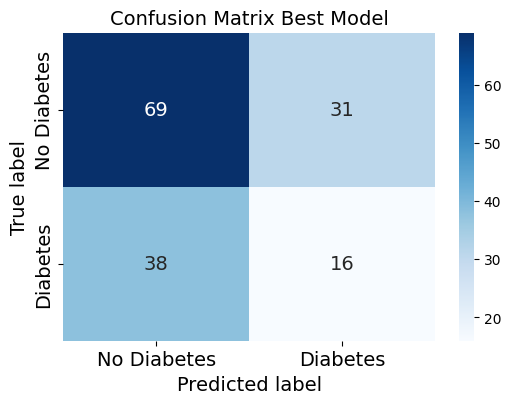

In [36]:
#Show some metrics results

# Get predictions
y_pred_best = (best_model.predict(X_test) > 0.5).astype(int)

# Calculate classification report
best_report = classification_report(y_test, y_pred_best, target_names=['No Diabetes', 'Diabetes'])
print(f'Classification Report Best Model :\n{best_report}')

# Get the test accuracy
print(f'Best Model Max-validation accuracy: {test_acc}')

# Calculate confusion matrix
best_cm = confusion_matrix(y_val, y_pred_best)

def plot_confusion_matrix(cm, classes, fontsize=14):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes, 
                annot_kws={"size": fontsize})  # Set annotation font size
    plt.ylabel('True label', fontsize=fontsize)
    plt.xlabel('Predicted label', fontsize=fontsize)
    plt.title('Confusion Matrix Best Model', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)  # Set x-tick label font size
    plt.yticks(fontsize=fontsize)  # Set y-tick label font size
    plt.show()

# Define class names
class_names = ['No Diabetes', 'Diabetes']

# Plot the confusion matrix
plot_confusion_matrix(best_cm, class_names, fontsize=14)


In [31]:
import joblib
# Save the model using joblib
joblib_file = "model.pkl"
joblib.dump(model, joblib_file)

print(f"Model saved to {joblib_file}")

INFO:tensorflow:Assets written to: ram://167203ea-ba25-4229-ab11-4bf5e16e915e/assets
Model saved to model.pkl


In [32]:
# Save the model using joblib
joblib_file = "model_opt1.pkl"
joblib.dump(model_opt1, joblib_file)

print(f"Model saved to {joblib_file}")

INFO:tensorflow:Assets written to: ram://a0f7a725-d42e-48b7-b5c5-e448177c2773/assets
Model saved to model_opt1.pkl


In [33]:
# Save the model using joblib
joblib_file = "model_opt2.pkl"
joblib.dump(model_opt2, joblib_file)

print(f"Model saved to {joblib_file}")

INFO:tensorflow:Assets written to: ram://c1c0a4ae-9914-43ac-8c6a-dc872c8564ed/assets
Model saved to model_opt2.pkl


In [34]:
# Save the model using joblib
joblib_file = "model_opt3.pkl"
joblib.dump(model_opt3, joblib_file)

print(f"Model saved to {joblib_file}")

INFO:tensorflow:Assets written to: ram://5d0f2e90-6fe6-48f4-85d4-2f8109c56c66/assets
Model saved to model_opt3.pkl


In [ ]:
# Load the model using joblib
loaded_model = joblib.load(joblib_file)

# Or load the model using pickle
with open('random_forest_model_pickle.pkl', 'rb') as f:
    loaded_model_pickle = pickle.load(f)

# You can now use the loaded model to make predictions
predictions = loaded_model.predict(X_test)
print("Predictions:", predictions)
